In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from otofu.jasmine import HZperiod, get_mtticks, assign_snHZ

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

In [3]:
# dtoinodup: TESS candidates (TOIs) - TESS confimed planets
# dconf_tess: TESS confirmed planets
# dconf_kepler: confirmed planets from Kepler/K2
# dconf_other: other confirmed planets
d = pd.HDFStore('compiled_catalog.h5')
datakeys = [k[1:] for k in d.keys()]
datakeys = list(np.array(datakeys)[[0,1,3,2]]) # change order
datadict = dict(zip(datakeys, [assign_snHZ(d[key], 'mass', 'rad', 'Teff', 'Jmag', 'Hmag') for key in datakeys]))
d.close()
print (datakeys)

Hw outside the valid range: [7.756708395177219, 12.756708395177219]
Hw outside the valid range: [7.756708395177219, 12.756708395177219]
Hw outside the valid range: [7.756708395177219, 12.756708395177219]
Hw outside the valid range: [7.756708395177219, 12.756708395177219]
['TESS candidate', 'TESS confirmed', 'Kepler/K2', 'ground']


In [4]:
#%% CTL dwarfs
d = pd.read_csv('data/CTLv8_t4000_h11.csv', comment='#')
d = d[d.rad<0.6].reset_index(drop=True)
_ = assign_snHZ(d, 'mass', 'rad', 'Teff', 'Jmag', 'Hmag')

Hw outside the valid range: [7.756708395177219, 12.756708395177219]


In [5]:
def simulate(ds):
    rands = np.random.rand(len(ds))
    idx = rands < ds.ptraHZ
    return ds[idx].reset_index(drop=True)

Nsim = 10000
sn_threshold = 7
res = pd.DataFrame({})
for i in range(Nsim):
    dsim = simulate(d)
    res = res.append(dsim[dsim.snHZ>sn_threshold][["Hwmag", "mass"]])
    #res = res.append(dsim[["Hmag", "mass", "snHZ"]])

In [6]:
#x, y = np.array(res.Hmag[res.snHZ>10]), np.array(res.mass[res.snHZ>10])
x, y = np.array(res.Hwmag), np.array(res.mass)
#medges = np.arange(0.05, 0.55, 0.07)
medges = np.arange(0.08, 0.60, 0.08)
medges[-1] = 0.55
mvals = 0.5 * (medges[1:] + medges[:-1])

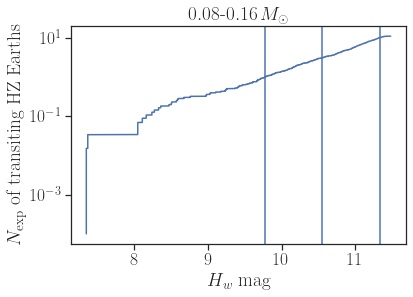

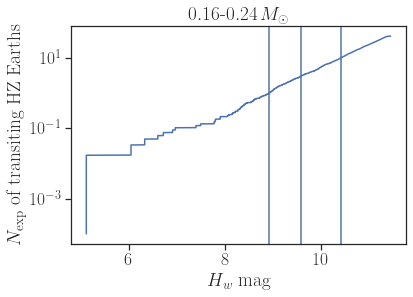

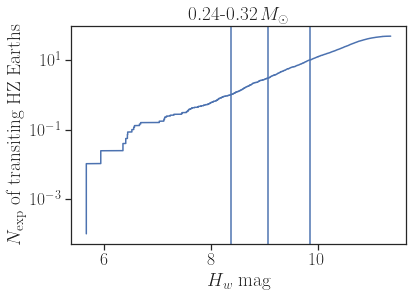

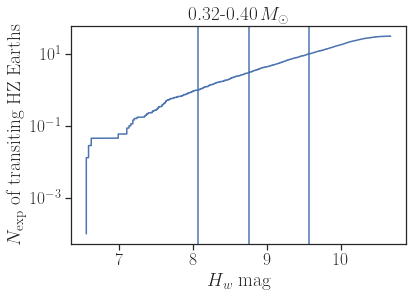

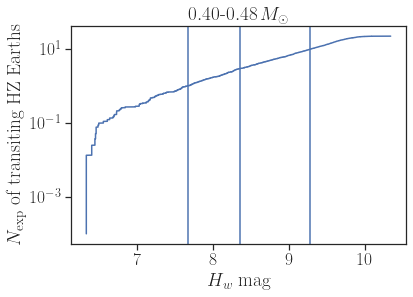

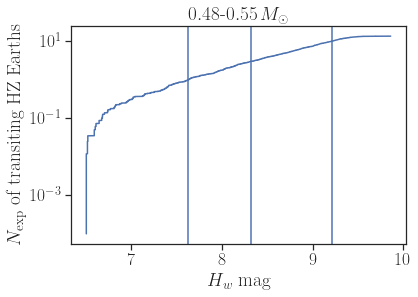

In [7]:
hmag1, hmag3, hmag10 = [], [], []
for mu, ml in zip(medges[1:], medges[:-1]):
    _idx = (ml<=y) & (y<mu)
    plt.figure()
    plt.title("$%.2f$-$%.2f\,M_\odot$"%(ml, mu))
    plt.xlabel("$H_w$ mag")
    plt.ylabel("$N_\mathrm{exp}$ of transiting HZ Earths")
    #plt.hist(x[_idx], cumulative=True, weights=w[_idx])
    sortx = np.sort(x[_idx])
    yval = np.cumsum(np.ones_like(sortx)) / Nsim
    if np.max(yval)>1:
        hmag1.append(sortx[np.argmin(np.abs(yval-1.))])
    else:
        hmag1.append(np.nan)
    if np.max(yval)>3:
        hmag3.append(sortx[np.argmin(np.abs(yval-3.))])
    else:
        hmag3.append(np.nan)
    if np.max(yval)>10:
        hmag10.append(sortx[np.argmin(np.abs(yval-10.))])
    else:
        hmag10.append(np.nan)
    plt.yscale('log')
    plt.axvline(x=hmag1[-1])
    plt.axvline(x=hmag3[-1])
    plt.axvline(x=hmag10[-1])
    plt.plot(sortx, yval)
hmag1 = np.array(hmag1)
hmag3 = np.array(hmag3)
hmag10 = np.array(hmag10)

In [8]:
mticks, tticks = get_mtticks()

In [13]:
symbols, sizes = ['^', 's', 'o', '*'], [8, 8, 8, 16]
symbols, sizes = ['^', '*', 'o', 's'], [8, 16, 8, 8]# swarpped stars and squares

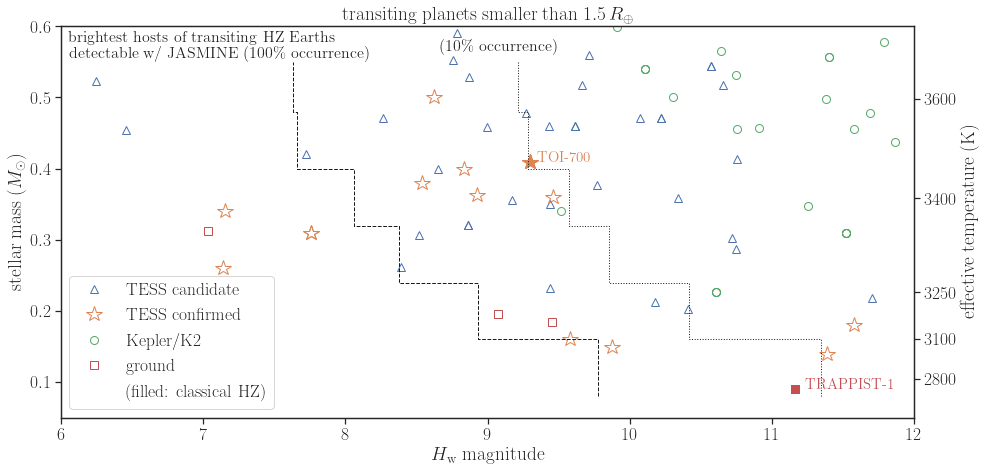

In [14]:
fig = plt.figure(figsize=(17*0.9,8*0.9))
ax = fig.gca()
ax.set_ylabel("stellar mass ($M_\odot$)")
ax.set_xlabel("$H_\mathrm{w}$ magnitude")
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(6, 12)
plt.ylim(0.05, 0.6)

#"""
for i, (key, marker, size) in enumerate(zip(datakeys, symbols, sizes)):
    _d = datadict[key]
    _idx = (_d.pl_rade < 1.5)
    plt.plot(_d["Hwmag"][_idx], _d["mass"][_idx], '.', marker=marker, mfc='none', label=key, color='C%d'%i, markersize=size)
    _idx = (_d.pl_rade < 1.5) & (HZperiod(_d.mass, s=0.85)<_d.pl_orbper) & (_d.pl_orbper<HZperiod(_d.mass, s=0.25))
    plt.plot(_d["Hwmag"][_idx], _d["mass"][_idx], '.', marker=marker, color='C%d'%i, markersize=size)
#"""

plt.plot(8, 0.1, '.', markersize=0, label='(filled: classical HZ)')

""" line
cont1 = np.poly1d(np.polyfit(hmag1[hmag1==hmag1], mvals[hmag1==hmag1], deg=3))
cont3 = np.poly1d(np.polyfit(hmag3[hmag3==hmag3], mvals[hmag3==hmag3], deg=3))
cont10 = np.poly1d(np.polyfit(hmag10[hmag10==hmag10], mvals[hmag10==hmag10], deg=3))

h0 = np.linspace(7, 10, 100)
plt.plot(h0, cont1(h0), ls='--', lw=1, color='k')

h0 = np.linspace(7.5, 10.5, 100)
plt.plot(h0, cont3(h0), ls='--', lw=1, color='k')

h0 = np.linspace(8.6, 11, 100)
plt.plot(h0, cont10(h0), ls='dotted', lw=1, color='k')
"""

""" points
plt.plot(hmag1, mvals, 'o', color='tan')
plt.plot(hmag3, mvals, 'o', color='tan')
plt.plot(hmag10, mvals, 'o', color='tan')
"""

# step
plt.plot(np.sort(np.tile(hmag1, 2))[::-1], np.sort(np.r_[medges[1:], medges[0:-1]]), ls='dashed', lw=1, color='k')
#plt.plot(np.sort(np.tile(hmag3, 2))[::-1], np.sort(np.r_[medges[1:], medges[:-1]]), ls='dotted', lw=1, color='k')
plt.plot(np.sort(np.tile(hmag10, 2))[::-1], np.sort(np.r_[medges[1:], medges[0:-1]]), ls='dotted', lw=1, color='k')

#plt.text(7.5-0.5, 0.54, "brightest transiting HZ Earth\n(100\% occurrence)", ha='right', va='bottom', fontsize=16)
plt.text(6.05, 0.54+0.01, r"brightest hosts of transiting HZ Earths\\\phantom{aa}detectable w/ JASMINE (100\% occurrence)", 
                     ha='left', va='bottom', fontsize=16)
plt.text(9.5, 0.54+0.02, "(10\% occurrence)", ha='right', va='bottom', fontsize=16)

plt.text(9.35, 0.41, r"TOI-700", color="C1", fontsize=15)
plt.text(11.23, 0.09, r"TRAPPIST-1", color="C3", fontsize=15)

plt.title("transiting planets smaller than $1.5\,R_\oplus$")
plt.legend(loc='lower left')

ax2 = ax.twinx()
ax2.set_xscale('linear')#, subsx=[-2])
ax2.set_yticks(mticks)
ax2.set_yticklabels(['${0:d}$'.format(int(t)) for t in tticks])
ax2.set_ylabel("effective temperature (K)")
ax2.set_ylim(0.05, 0.6)

plt.savefig("brightest.png", dpi=200, bbox_inches="tight");